# IA - Labyrinthe
## Auteur:
- Bastien Wermeille

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import random
from enum import Enum

from datetime import datetime
random.seed(datetime.now())

In [2]:
WALL_RATIO = 0.3
MAX_TIME_S = 20
LOG = True
POPULATION_LENGTH = 150
MUTPB = 0.7
CXPB = 0.2
INDPB = 0.5

## General tools

In [3]:
def generate_labyrinth(width, height, wall_ratio=WALL_RATIO):
    """
    Generate a random labyrinth
    
    :param width:
    :param height:
    :param wall_ratio:
    :returns: (grid, start_cell, end_cell)
    """
    grid = np.random.rand(width, height)
    grid[grid >= 1 - wall_ratio] = 1
    grid[grid < 1 - wall_ratio] = 0
    free_cell_top = [i for i in range(0, width) if grid[0][i] != 1]
    start_idx = random.choice(free_cell_top)
    start_cell = (0, start_idx)
    free_cell_bottom = [i for i in range(0, width) if grid[-1][i] != 1]
    end_idx = random.choice(free_cell_bottom)
    end_cell = (height - 1, end_idx)
    return grid, start_cell, end_cell

In [4]:
def display_labyrinth(grid, start_cell, end_cell, solution=None):
    '''
    Generate a random labyrinth
    
    :param grid: of the maze
    :param start_cell:
    :param end_cell:
    :param solution: allow to display the solution
    '''
    grid = np.array(grid, copy=True)
    FREE_CELL = 19
    WALL_CELL = 16
    START = 0
    END = 0
    PATH = 2
    
    grid[grid == 0] = FREE_CELL
    grid[grid == 1] = WALL_CELL
    
    if solution:
        for cell in solution:
            grid[cell] = PATH
    else:
        print("No solution has been found")
    
    grid[start_cell] = START
    grid[end_cell] = END
    
    plt.matshow(grid, cmap="tab20c")

In [5]:
def load_grid(grid_file):
    """
    Load a labyrinth from a file
    
    :param grid_file:
    :returns: (grid, (height, width))
    """
    grid = np.load(grid_file)
    h = grid.shape[0]
    w = grid.shape[1]
    return (grid, (h, w))

In [6]:
# grid, START_LOCATION, END_LOCATION = generate_labyrinth(WIDTH, HEIGHT, WALL_RATIO)
grid, size = load_grid("grids/grid40.npy")
WIDTH = size[0]
HEIGHT = size[1]
START_LOCATION = (0,0)
END_LOCATION = (size[0]-1,size[1]-1)
if WIDTH == 10:
    CHROMOSOME_LENGTH = 25
elif WIDTH == 15:
    CHROMOSOME_LENGTH = 32
elif WIDTH == 20:
    CHROMOSOME_LENGTH = 45
elif WIDTH == 40:
    CHROMOSOME_LENGTH = 155
else:
    CHROMOSOME_LENGTH = int((WIDTH+HEIGHT)+(1-WALL_RATIO)*WIDTH+(1-WALL_RATIO)*HEIGHT)

No solution has been found
Width :  40  Height :  40
Chromosone Length :  155


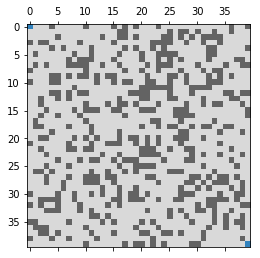

In [7]:
display_labyrinth(grid, START_LOCATION, END_LOCATION)
print("Width : ", WIDTH, " Height : ", HEIGHT)
print("Chromosone Length : ", CHROMOSOME_LENGTH)

# Data Structure

In [8]:
DIRECTIONS = {
    0: (-1, 0), # TOP
    1: (0, 1),  # RIGHT
    2: (1, 0),  # BOTTOM
    3: (0, -1), # LEFT
}
DIRECTIONS_LENGTH = len(DIRECTIONS)

## Genetic tools

In [9]:
def check_duplication_point(location, direction, previous_locations):
    """
    Check if a given location as already been visited and if this location is crossable
    
    :param location: location to analyse
    :param direction: given direction to check
    :param previous_locations: list of the previous locations
    :returns: boolean disponibility of the location
    """
    location_new = tuple(np.add(location, DIRECTIONS[direction]))
    return grid[location_new] != 1.0 and location_new not in previous_locations

In [10]:
def available_direction(location, previous_locations, start_location, targeted_location):
    """
    Return a list of the available move at a given location regarding the previous visited locations
    
    :param location: location to analyse
    :param direction: given direction to check
    :param previous_locations: list of the previous locations
    :returns: list of available moves
    """
    directions = []
    res = tuple(np.subtract(targeted_location, start_location))
    
    if location[0] > 0:
        if check_duplication_point(location, 0, previous_locations):
            directions.append(0)
            if res[0]<0:
                directions.append(0)
                directions.append(0)
    if location[0] < HEIGHT-1:
        if check_duplication_point(location, 2, previous_locations):
            directions.append(2)
            if res[0]>0:
                directions.append(2)
                directions.append(2)
    if location[1] > 0:
        if check_duplication_point(location, 3, previous_locations):
            directions.append(3)
            if res[1]<0:
                directions.append(3)
                directions.append(3)
    if location[1] < WIDTH-1:
        if check_duplication_point(location, 1, previous_locations):
            directions.append(1)
            if res[1]>0:
                directions.append(1)
                directions.append(1)
    
    return directions

In [11]:
def available_direction_simple(location):
    """
    Return a list of the avilable move at a given location without regarding the previous visited locations
    
    :param location: locations to analyse
    :returns: list of available moves
    """
    directions = []
    
    if location[0] > 0:
        location_new = tuple(np.add(location, DIRECTIONS[0]))
        if grid[location_new] != 1.0:
            directions.append(0)
    if location[0] < HEIGHT-1:
        location_new = tuple(np.add(location, DIRECTIONS[2]))
        if grid[location_new] != 1.0:
            directions.append(2)
    if location[1] > 0:
        location_new = tuple(np.add(location, DIRECTIONS[3]))
        if grid[location_new] != 1.0:
            directions.append(3)
    if location[1] < WIDTH-1:
        location_new = tuple(np.add(location, DIRECTIONS[1]))
        if grid[location_new] != 1.0:
            directions.append(1)
    
    return directions

In [12]:
def validate_individual(individual, start_location, targeted_location):
    """
    Make an individual valid as he doesn't cross any wall
    
    :param individual: given individual
    :param start_location: start location in the grid
    :param targeted_location: targeted location
    :returns: validated invdividual
    """
    previous_locations = set([start_location])
    location = start_location
    direction = None
    end = False
    
    for index, direction in enumerate(individual):
        if end:
            continue
        
        # Validate every direction in an individual
        directions = available_direction(location, previous_locations, start_location, targeted_location)
        if len(directions) == 0:
            direction = random.choice(available_direction_simple(location))
        elif direction not in directions:
            # Find another valid direction
            direction = random.choice(directions)
        
        # Compute new location
        location = tuple(np.add(location, DIRECTIONS[direction]))
        
        individual[index] = direction
        previous_locations.add(location)
        
        if location == targeted_location:
            end = True
    
    return individual#, previous_locations

In [13]:
def compute_individual_to_directions(individual, start_location):
    """
    Compute an individual and return the list of the locations visited in order
    
    :param individual: 
    :param start_location:
    :returns: computed path
    """
    locations = [start_location]
    location = start_location
    for direction in individual:
        location = tuple(np.add(location, DIRECTIONS[direction]))
        locations.append(location)
    return locations

In [14]:
def optimise_individual(individual, locations):
    '''
    Optimise an individual to remove useless moves using only the individual information and its computed path
    
    :param individual: given individual
    :param locations: computed locations of the individual
    :returns: optimised individual
    '''
    
    i = 0
    # remove detour passing by same location
    while i < len(individual):
        if locations[i] in locations[i+1:]:
            index = locations[i+1:].index(locations[i])+i+1
            individual[:] = individual[:i]+individual[index:]
            locations[:] = locations[:i]+locations[index:]
        i += 1
    
    i=0
    while i < len(individual)-2:
        if individual[i] == (individual[i+2]+2)%4 and individual[i+1]%2 != individual[i]%2:
            individual[i] = individual[i+1]
            individual[:] = individual[:i+1]+individual[i+3:]
        i += 1
    
    return individual

In [15]:
def evaluate(individual, start_location, targeted_location):
    '''
    Evaluate an individual and return it's score but first make it valid and optimise it
    
    :param individual: given individual
    :param start_location: start location
    :param targeted_location: targeted location
    '''
    individual = validate_individual(individual, start_location, targeted_location)
    locations = compute_individual_to_directions(individual, start_location)
    
    if targeted_location in locations:
        individual[:] = individual[:locations.index(targeted_location)]
        locations[:] = locations[:locations.index(targeted_location)+1]
        
        individual[:] = optimise_individual(individual, locations)
        
        # Score equals to the length of the path
        score = len(individual)
    else:
        # Score equals to length of the individual + the remaining distance
        distance = tuple(np.subtract(locations[-1], targeted_location))
        manhattan_distance = abs(distance[0])+abs(distance[1])
        score = len(individual) + manhattan_distance
        score *= score
    return score,

## Deap Framework

In [16]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import operator
from enum import Enum
from collections import namedtuple
import random
import time

In [17]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [18]:
toolbox.register("direction", random.randint, 0, DIRECTIONS_LENGTH-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.direction, CHROMOSOME_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selBest)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=INDPB)
toolbox.register("evaluate", evaluate, start_location=START_LOCATION, targeted_location=END_LOCATION)

## Application interface

In [19]:
def solve_labyrinth_cycle(grid, start_location, end_location, nb_cycles):
    '''
    Run the solving algorithmes with a given number of cycles
    
    :param grid np.array: numpy 2d array
    :start_cell tuple: tuple of i, j indices for the start cell
    :end_cell tuple: tuple of i, j indices for the end cell
    :max_time_s float: maximum time for running the algorithm
    :returns: list of successive tuple i, j indices who forms the path
    """

    '''
    population = toolbox.population(POPULATION_LENGTH)
    halloffame = tools.HallOfFame(1)
    
    print("\t Start Computing")
    print("-------------------------------------")
    print("Nb cycles : ", nb_cycles)
    print("Population length : ", POPULATION_LENGTH)
    print("Individual length : ", CHROMOSOME_LENGTH)
    print("CXPB : ", CXPB)
    print("MUTPB : ", MUTPB)
    print("-------------------------------------")
    
    res = algorithms.eaSimple(population, toolbox,CXPB, MUTPB, nb_cycles, halloffame=halloffame, verbose=False)
    
    print("Best result:")
    print("\t Length : ", len(halloffame[0]) )
    
    solution = compute_individual_to_directions(halloffame[0], start_location)
    
    return solution

In [20]:
def solve_labyrinth(grid, start_location, end_location, max_time_s):
    '''
    Run the solving algorithmes with a given number of time
    
    :param grid: grid of the labyrinth
    :param start_location: start location
    :param targeted_location: targeted location
    :param max_time_s: maximum time to run this test
    :returns: final population
    '''
    population = toolbox.population(POPULATION_LENGTH)
    halloffame = tools.HallOfFame(1)
    
    print("\t Start computing")
    print("-------------------------------------")
    print("Time available : %s secondes" % max_time_s)
    print("Population length : ", POPULATION_LENGTH)
    print("Individual length : ", CHROMOSOME_LENGTH)
    print("CXPB : ", CXPB)
    print("MUTPB : ", MUTPB)
    print("-------------------------------------")
    
    start_time = inter_time = time.time()
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)
    
    nb_gen = 0
    
    # Begin the generational process
    while inter_time - start_time < max_time_s:
        nb_gen += 1
        
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, CXPB, MUTPB)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Measue time
        inter_time = time.time()
        
        # Log
        if LOG: # Debug interface influence par le travail de Damian Petroff
            solution = compute_individual_to_directions(halloffame[0], start_location)
            complete = end_location in solution
            print("[%s] | Time %.2f s | Length %s | Complete %s" % (nb_gen, round(inter_time - start_time, 2), len(halloffame[0]), complete))
        
    res = population
    
    print("-------------------------------------")
    print("Nb Generations : ", nb_gen)
    print("Best result:")
    print("\t Length : ", len(halloffame[0]) )
    
    solution = compute_individual_to_directions(halloffame[0], start_location)
    
    return solution

	 Start Computing
-------------------------------------
Nb cycles :  25
Population length :  150
Individual length :  155
CXPB :  0.2
MUTPB :  0.7
-------------------------------------
Best result:
	 Length :  92


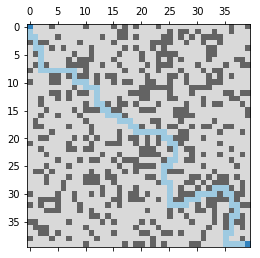

In [21]:
solution = solve_labyrinth_cycle(grid, START_LOCATION, END_LOCATION, 25)
display_labyrinth(grid, START_LOCATION, END_LOCATION, solution)

	 Start computing
-------------------------------------
Time available : 20 secondes
Population length :  150
Individual length :  155
CXPB :  0.2
MUTPB :  0.7
-------------------------------------
[1] | Time 1.61 s | Length 155 | Complete False
[2] | Time 2.34 s | Length 155 | Complete False
[3] | Time 3.04 s | Length 155 | Complete False
[4] | Time 3.71 s | Length 155 | Complete False
[5] | Time 4.48 s | Length 104 | Complete True
[6] | Time 5.18 s | Length 104 | Complete True
[7] | Time 5.92 s | Length 104 | Complete True
[8] | Time 6.64 s | Length 104 | Complete True
[9] | Time 7.29 s | Length 100 | Complete True
[10] | Time 8.04 s | Length 100 | Complete True
[11] | Time 8.79 s | Length 100 | Complete True
[12] | Time 9.45 s | Length 100 | Complete True
[13] | Time 10.15 s | Length 100 | Complete True
[14] | Time 10.91 s | Length 100 | Complete True
[15] | Time 11.66 s | Length 100 | Complete True
[16] | Time 12.39 s | Length 100 | Complete True
[17] | Time 13.09 s | Length 98 | C

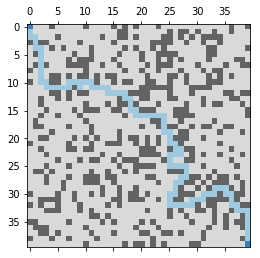

In [22]:
solution = solve_labyrinth(grid, START_LOCATION, END_LOCATION, MAX_TIME_S)
display_labyrinth(grid, START_LOCATION, END_LOCATION, solution)

# Conclusion
## Fonctionnement global
L'algorithme génétique développé pour ce projet se base sur deux points clés, nous générons des individus aléatoires qui ne sont pas forcément valides, ceux-ci peuvent passer par des murs puis seulement lors de l'évaluation, une fonction validate_individual va modifier chaque individu afin de la rendre valide. Dans le cas ou un individu atteint la destination, alors celui-ci est optimisé afin de réduire sa taille et ainsi son score.

## Fonction de fitness
La fonction de fitness possède deux cas de figure. La première lorsque la destination est atteinte et dans ce cas le score vaut la taille de l'individu.

Et le deuxième cas lorsque la destination n'est pas atteinte. Dans ce cas le score est égal au carré de, la longueur de l'individu additionné à la distance de manhattan (entre la dernière position de l'individu et le point d'arrivé). Cette fonction donnera ainsi toujours un résultat plus petit à un individu qui atteint la destination.

Le carré permet d'être certain qu’un individu ayant atteint la destination ait un score plus petit afin que ce soit lui qui soit retenu. Ce cas présent peut être rencontré dans le cas ou tous les individus n'ont pas la même taille.

## Choix des hyperparamètres

### Mutations
INDPB = 0.5
MUTPB = 0.7

La mutation est un point important et pour ce faire, la fonction shuffle a été utilisée, celle-ci a l'avantage de conserver les "directions" de l'individu. Les mutations vont ainsi permettre d'explorer des chemins semblables aux précédents afin de trouver des raccourcis.

la fonction shuffle a donc comme avantage de ne pas faire régresser les précédents choix effectués dans les directions, mais permet de réagencer ces directions afin de les optimiser. Une fonction random elle conduirait dans la majorité des cas à une régression ce qui est absolument à éviter.

La probabilité de muter d'un individu est de 0.5 et chaque gêne(direction) de l'individu est de 0.7.

### Cross-over
CXPB = 0.2

La fonction de cross-over choisi est cxOnePoint. la fonction de cross-over n'est pas très utile, mais permet globalement d'éviter que l'algorithme se trouve coincer dans une zone bloquée.

### Sélection
INDPB = 0.5

Pour la sélection, seuls les meilleurs éléments sont retenus afin d'augmenter la convergence vers un résultat. Cette option est valable dans ce type de labyrinthes, car la probabilité de mur est très faible, 0.3.

### Population
POPULATION_LENGTH = 150

Le choix de la taille de la population est important, car plus elle est importante moins le nombre de cycles possible va être élevé. Pour ce faire, j'ai chois une population de 150 ce qui me permet d'avoir environ 25 cycles pour 20 secondes (grille de 40x40).

## Optimisation
Lorsqu'une solution est trouvée, celle-ci est améliorée afin de supprimer d'éventuels mouvements avant arrière ou de visiter 4 cases adjacentes. Cet algorithme permet de simplifier ces cas particuliers et de raccourcir l'individu.

## Résultat
Le code ci-dessus est fonctionnel et permet de toujours trouver un résultat pour autant qu'on lui laisse un minimum de temps adapté à la taille du labyrinthe.

## Analyse
Les algorithmes génétiques permettent de résoudre des labyrinthes cependant ceux-ci ne sont pas du tout optimal pour ce genre de projets et l'utilisation d'algorithmes tel que A* seraient a privilégier. Ceux-ci permettent en effet de résoudre de manière optimale un labyrinthe. Les algorithmes génétiques ne sont pas appropriés pour un projet tel que celui-ci ou l'utilisation de l'aléatoire n'est pas nécessaire pour trouver le chemin celui-ci pouvant être trouvé de manière prédictive.